Resampling Yeo7 to CC200 resolution...
Found 200 CC200 ROIs, 7 Yeo7 networks.

=== Winsorized Network-level comparison (ASD vs Control) ===
   NetworkID        NetworkName  ASD_n  CTRL_n    MeanASD   MeanCTRL  \
0          1             Visual     86      86 -39.481440 -40.482877   
1          2        SomatoMotor     86      86 -20.369428 -21.910694   
2          3         DorsalAttn     86      86  -8.994563  -9.070702   
3          4  Salience/VentAttn     86      86 -19.743966 -20.592302   
4          5             Limbic     86      86  -4.724726  -4.718780   
5          6     Frontoparietal     86      86 -16.451745 -16.026545   
6          7            Default     86      86 -39.908066 -42.429587   

    TTest_t   TTest_p  RankSum_stat  RankSum_p  
0  0.508462  0.611799      0.768675   0.442086  
1  1.599101  0.111672      1.773159   0.076202  
2  0.147693  0.882787      0.232746   0.815958  
3  0.974986  0.331066      0.134748   0.892811  
4 -0.021046  0.983236     -0.630865   

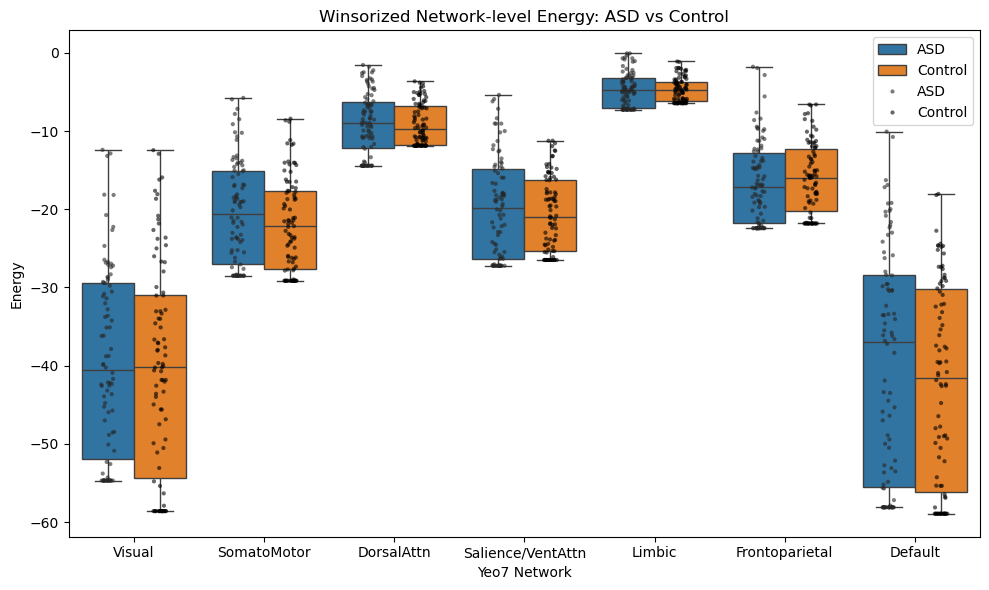

In [7]:
import os
import glob
import numpy as np
import nibabel as nib
import networkx as nx
from nibabel.processing import resample_from_to
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.stats import ttest_ind, ranksums

###############################################################################
# 1) BUILD ROI->NETWORK MAP BY OVERLAP (CC200 -> YEO7)
###############################################################################
def build_roi_to_network_map(cc200_file, yeo7_file):
    """
    For each ROI in the Craddock 200 atlas (cc200_file),
    find which Yeo7 network (1..7) it overlaps the most.
    Returns a dict: roi_to_net[roi_id] = net_id (1..7).
    """
    cc200_img = nib.load(cc200_file)
    cc200_data = cc200_img.get_fdata()

    yeo_img = nib.load(yeo7_file)
    yeo_data = yeo_img.get_fdata()

    # Resample Yeo7 if needed
    if cc200_data.shape != yeo_data.shape:
        print("Resampling Yeo7 to CC200 resolution...")
        yeo_img = resample_from_to(yeo_img, cc200_img, order=0)
        yeo_data = yeo_img.get_fdata()

    roi_ids = np.unique(cc200_data[cc200_data>0])  # e.g. 1..200
    yeo_ids = np.unique(yeo_data[yeo_data>0])      # e.g. 1..7

    print(f"Found {len(roi_ids)} CC200 ROIs, {len(yeo_ids)} Yeo7 networks.")

    roi_to_net = {}
    for roi in roi_ids:
        mask = (cc200_data == roi)
        overlap_counts = {}
        for net in yeo_ids:
            overlap_counts[net] = np.sum(yeo_data[mask] == net)
        # find net with maximum overlap
        best_net = max(overlap_counts, key=overlap_counts.get)
        roi_to_net[int(roi)] = int(best_net)

    return roi_to_net

###############################################################################
# 2) COMPUTE NETWORK ENERGY (SKIP NaN EDGES)
###############################################################################
def compute_network_energy(graph, roi_to_net, net_id):
    """
    E_net = - sum_{(u,v)} [fALFF[u]*weight[u,v]*fALFF[v]]
    for edges (u,v) where roi_to_net[u_int] == net_id and roi_to_net[v_int] == net_id.
    Skips edges if any relevant value is None or NaN.
    """
    energy_sum = 0.0
    
    for u, v, data in graph.edges(data=True):
        # Convert string IDs to int
        try:
            u_int = int(u)
            v_int = int(v)
        except ValueError:
            # If parsing fails, skip
            continue

        # Check if both nodes belong to the same Yeo7 network
        if roi_to_net.get(u_int, None) == net_id and roi_to_net.get(v_int, None) == net_id:
            falff_u = graph.nodes[u].get('fALFF', None)
            falff_v = graph.nodes[v].get('fALFF', None)
            w = data.get('weight', None)

            # Skip if missing or NaN
            if (falff_u is None) or (falff_v is None) or (w is None):
                continue
            if any(np.isnan([falff_u, falff_v, w])):
                continue

            energy_sum += falff_u * w * falff_v

    return -energy_sum

###############################################################################
# 3) WINSORIZE FUNCTION (CLIP OUTLIERS AT 1ST & 99TH PERCENTILES)
###############################################################################
def winsorize_values(values, lower=1.0, upper=99.0):
    """
    Clip (winsorize) the data array 'values' at the given lower and upper percentiles.
    This prevents extreme outliers from dominating.
    E.g., lower=1.0, upper=99.0 => clip everything below the 1st percentile
    and above the 99th percentile to those boundary values.
    """
    if len(values) == 0:
        return values  # no data
    low_val = np.percentile(values, lower)
    high_val = np.percentile(values, upper)
    clipped = np.clip(values, low_val, high_val)
    return clipped

###############################################################################
# 4) MAIN SCRIPT
###############################################################################
def main():
    # (A) Provide atlas paths
    cc200_file = r"D:\Project_001\NETWORK_FINAL\Atlas\CC200.nii"  # Craddock 200 atlas
    yeo7_file  = r"D:\Project_001\NETWORK_FINAL\Atlas\Yeo7_1mm_reoriented.nii.gz"  # Yeo 7 network parcellation

    # Build the ROI->network map
    roi_to_net = build_roi_to_network_map(cc200_file, yeo7_file)

    # (B) Directories for ASD & Control GraphML
    asd_dir   = r"D:\Project_001\NETWORK_FINAL\ASDNetworks\Partially_Full"
    ctrl_dir  = r"D:\Project_001\NETWORK_FINAL\ControlNetworks\Partially_Full"

    asd_files  = glob.glob(os.path.join(asd_dir, "*.graphml"))
    ctrl_files = glob.glob(os.path.join(ctrl_dir, "*.graphml"))
    
    # Yeo 7 networks typically labeled 1..7
    network_ids = [1,2,3,4,5,6,7]
    # Optional naming
    network_labels = {
        1: "Visual",
        2: "SomatoMotor",
        3: "DorsalAttn",
        4: "Salience/VentAttn",
        5: "Limbic",
        6: "Frontoparietal",
        7: "Default"
    }

    # Data structures: net_energies_asd[net_id] = list of energies
    net_energies_asd = {net: [] for net in network_ids}
    net_energies_ctrl = {net: [] for net in network_ids}

    def compute_subject_net_energies(graph):
        """
        For one subject, compute E_net for each net_id (1..7).
        If the resulting E_net is NaN, store None.
        """
        sub_netE = {}
        for net in network_ids:
            E_val = compute_network_energy(graph, roi_to_net, net)
            if np.isnan(E_val):
                sub_netE[net] = None
            else:
                sub_netE[net] = E_val
        return sub_netE

    # (C) Process ASD
    for gf in asd_files:
        G = nx.read_graphml(gf)
        sub_netE = compute_subject_net_energies(G)
        for net in network_ids:
            if sub_netE[net] is not None:
                net_energies_asd[net].append(sub_netE[net])

    # (D) Process Control
    for gf in ctrl_files:
        G = nx.read_graphml(gf)
        sub_netE = compute_subject_net_energies(G)
        for net in network_ids:
            if sub_netE[net] is not None:
                net_energies_ctrl[net].append(sub_netE[net])
    
    # (E) Winsorize each network's energies to reduce outliers
    for net in network_ids:
        asd_array = np.array(net_energies_asd[net], dtype=float)
        ctrl_array = np.array(net_energies_ctrl[net], dtype=float)

        # Clip at 1st & 99th percentiles
        asd_array_w = winsorize_values(asd_array, lower=20.0, upper=99.0)
        ctrl_array_w = winsorize_values(ctrl_array, lower=20.0, upper=99.0)

        # Overwrite
        net_energies_asd[net] = asd_array_w.tolist()
        net_energies_ctrl[net] = ctrl_array_w.tolist()

    # (F) Compare each network's energy
    results = []
    for net in network_ids:
        asd_vals = np.array(net_energies_asd[net], dtype=float)
        ctrl_vals = np.array(net_energies_ctrl[net], dtype=float)
        net_name = network_labels.get(net, f"Net{net}")

        n_asd = len(asd_vals)
        n_ctrl = len(ctrl_vals)

        if n_asd < 2 or n_ctrl < 2:
            print(f"Not enough valid data for network {net_name} to compare.")
            continue
        
        # T-test
        t_res = ttest_ind(asd_vals, ctrl_vals, equal_var=False)
        # Wilcoxon rank-sum (Mann-Whitney)
        r_res = ranksums(asd_vals, ctrl_vals)

        row = {
            "NetworkID": net,
            "NetworkName": net_name,
            "ASD_n": n_asd,
            "CTRL_n": n_ctrl,
            "MeanASD": np.mean(asd_vals),
            "MeanCTRL": np.mean(ctrl_vals),
            "TTest_t": t_res.statistic,
            "TTest_p": t_res.pvalue,
            "RankSum_stat": r_res.statistic,
            "RankSum_p": r_res.pvalue
        }
        results.append(row)

    results_df = pd.DataFrame(results)
    print("\n=== Winsorized Network-level comparison (ASD vs Control) ===")
    print(results_df)

    # (G) Plot: a grouped boxplot for each of the 7 networks
    all_data = []
    for net in network_ids:
        net_name = network_labels.get(net, f"Net{net}")
        for val in net_energies_asd[net]:
            all_data.append({"Group":"ASD", "Network":net_name, "Energy":val})
        for val in net_energies_ctrl[net]:
            all_data.append({"Group":"Control", "Network":net_name, "Energy":val})
    df_all = pd.DataFrame(all_data)

    plt.figure(figsize=(10,6))
    sns.boxplot(x="Network", y="Energy", hue="Group", data=df_all, showfliers=False)
    sns.stripplot(x="Network", y="Energy", hue="Group", data=df_all,
                  dodge=True, alpha=0.6, palette='dark:black', size=3)
    plt.title("Winsorized Network-level Energy: ASD vs Control")
    plt.xlabel("Yeo7 Network")
    plt.ylabel("Energy")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Loading CC200 atlas: D:\Project_001\NETWORK_FINAL\Atlas\CC200.nii
Loading Yeo7 atlas: D:\Project_001\NETWORK_FINAL\Atlas\Yeo7_1mm_reoriented.nii.gz
Resampling Yeo7 to CC200 resolution...
Found 200 CC200 ROIs, 7 Yeo7 networks.
Found 21 outlier subjects across all networks.
Outlier subject IDs:
   0050130
   0050344
   0050391
   0050485
   0050496
   0050504
   0050520
   0050690
   0050694
   0050704
   0050711
   0051131
   0051237
   0051318
   0051322
   0051328
   0051329
   0051333
   0051340
   0051365
   0051607

=== Outlier-Excluded Network-level comparison (ASD vs Control) ===
   NetworkID        NetworkName  ASD_n  CTRL_n    MeanASD   MeanCTRL  \
0          1             Visual     71      80 -39.506391 -41.586533   
1          2        SomatoMotor     71      80 -19.962168 -22.219570   
2          3         DorsalAttn     71      80  -8.462871  -9.585219   
3          4  Salience/VentAttn     71      80 -19.178040 -20.958336   
4          5             Limbic     71      80 

C:\Users\Saeed\AppData\Local\Temp\ipykernel_16800\3857453805.py:265: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(x="Network", y="Energy", hue="Group", data=df_all,


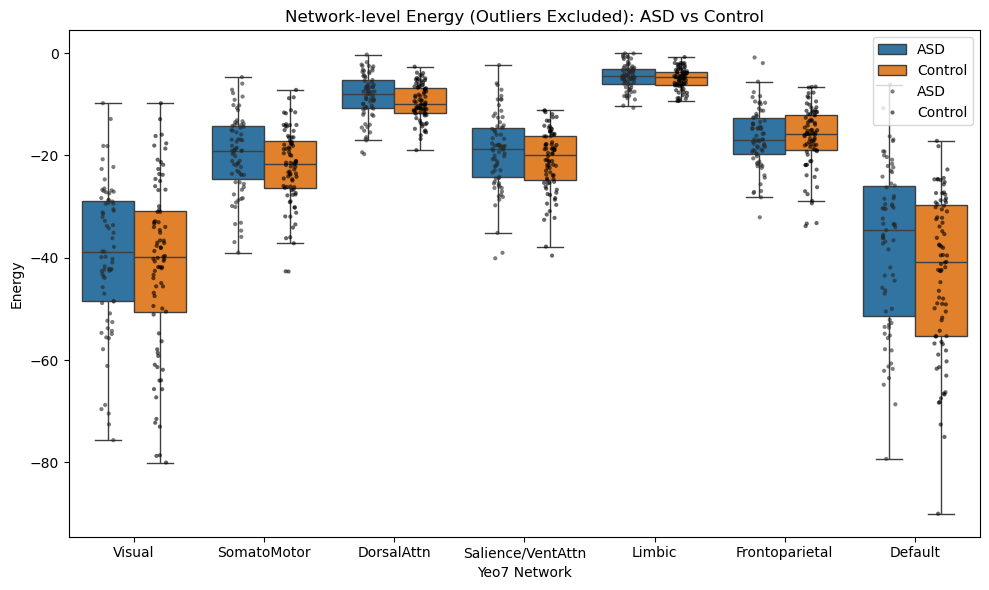

In [11]:
import os
import glob
import numpy as np
import nibabel as nib
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from nibabel.processing import resample_from_to
from scipy.stats import ttest_ind, ranksums

###############################################################################
# 1) BUILD ROI->NETWORK MAP (CC200 -> YEO7)
###############################################################################
def build_roi_to_network_map(cc200_file, yeo7_file):
    """
    For each ROI in the Craddock 200 atlas (cc200_file),
    find which Yeo7 network (1..7) it overlaps the most.
    Returns a dict: roi_to_net[roi_id] = net_id (1..7).
    """
    print("Loading CC200 atlas:", cc200_file)
    cc200_img = nib.load(cc200_file)
    cc200_data = cc200_img.get_fdata()

    print("Loading Yeo7 atlas:", yeo7_file)
    yeo_img = nib.load(yeo7_file)
    yeo_data = yeo_img.get_fdata()

    # Resample Yeo7 if needed
    if cc200_data.shape != yeo_data.shape:
        print("Resampling Yeo7 to CC200 resolution...")
        yeo_img = resample_from_to(yeo_img, cc200_img, order=0)
        yeo_data = yeo_img.get_fdata()

    roi_ids = np.unique(cc200_data[cc200_data>0])  # e.g. 1..200
    yeo_ids = np.unique(yeo_data[yeo_data>0])      # e.g. 1..7

    print(f"Found {len(roi_ids)} CC200 ROIs, {len(yeo_ids)} Yeo7 networks.")

    roi_to_net = {}
    for roi in roi_ids:
        mask = (cc200_data == roi)
        overlap_counts = {}
        for net in yeo_ids:
            overlap_counts[net] = np.sum(yeo_data[mask] == net)
        # find net with maximum overlap
        best_net = max(overlap_counts, key=overlap_counts.get)
        roi_to_net[int(roi)] = int(best_net)

    return roi_to_net

###############################################################################
# 2) COMPUTE SUB-NETWORK ENERGY (SKIP NaN)
###############################################################################
def compute_network_energy(graph, roi_to_net, net_id):
    """
    E_net = - sum_{(u,v)} [fALFF[u]*weight[u,v]*fALFF[v]]
    for edges (u,v) where roi_to_net[u_int] == net_id and roi_to_net[v_int] == net_id.
    Skips edges if any relevant value is None or NaN.
    """
    energy_sum = 0.0
    
    for u, v, data in graph.edges(data=True):
        # Convert string IDs to int
        try:
            u_int = int(u)
            v_int = int(v)
        except ValueError:
            continue

        if roi_to_net.get(u_int, None) == net_id and roi_to_net.get(v_int, None) == net_id:
            falff_u = graph.nodes[u].get('fALFF', None)
            falff_v = graph.nodes[v].get('fALFF', None)
            w = data.get('weight', None)

            # Skip if missing or NaN
            if (falff_u is None) or (falff_v is None) or (w is None):
                continue
            if any(np.isnan([falff_u, falff_v, w])):
                continue

            energy_sum += falff_u * w * falff_v

    return -energy_sum

###############################################################################
# 3) IQR-BASED OUTLIER DETECTION
###############################################################################
def identify_outliers_iqr(values, iqr_factor=1.5):
    """
    Returns a boolean mask of outliers:
      below Q1 - iqr_factor*IQR or above Q3 + iqr_factor*IQR.
    """
    if len(values) < 2:
        return np.zeros(len(values), dtype=bool)

    q1 = np.percentile(values, 25)
    q3 = np.percentile(values, 75)
    iqr = q3 - q1
    lower_bound = q1 - iqr_factor * iqr
    upper_bound = q3 + iqr_factor * iqr

    return (values < lower_bound) | (values > upper_bound)

###############################################################################
# 4) PARSE SUBJECT ID FROM FILENAME
###############################################################################
def parse_subject_id(fname):
    """
    E.g. "Pitt_0050007_network.graphml" => subject_id = "0050007"
    Adjust if your naming pattern differs.
    """
    base = os.path.basename(fname)
    no_ext = os.path.splitext(base)[0]
    parts = no_ext.split('_')
    if len(parts) >= 2:
        return parts[1]
    else:
        return no_ext

###############################################################################
# 5) MAIN
###############################################################################
def main():
    # (A) Provide atlas paths
    cc200_file = r"D:\Project_001\NETWORK_FINAL\Atlas\CC200.nii"
    yeo7_file  = r"D:\Project_001\NETWORK_FINAL\Atlas\Yeo7_1mm_reoriented.nii.gz"

    # Build the ROI->network map
    roi_to_net = build_roi_to_network_map(cc200_file, yeo7_file)

    # (B) Directories for ASD & Control GraphML
    asd_dir   = r"D:\Project_001\NETWORK_FINAL\ASDNetworks\Partially_Full"
    ctrl_dir  = r"D:\Project_001\NETWORK_FINAL\ControlNetworks\Partially_Full"

    asd_files  = glob.glob(os.path.join(asd_dir, "*.graphml"))
    ctrl_files = glob.glob(os.path.join(ctrl_dir, "*.graphml"))
    
    if not asd_files and not ctrl_files:
        print("No GraphML files found in either directory. Exiting.")
        return

    # Yeo 7 networks
    network_ids = [1,2,3,4,5,6,7]
    network_labels = {
        1: "Visual",
        2: "SomatoMotor",
        3: "DorsalAttn",
        4: "Salience/VentAttn",
        5: "Limbic",
        6: "Frontoparietal",
        7: "Default"
    }

    # We'll store sub-network energies as:
    # net_energies_asd[net] = list of (subject_id, energy)
    # net_energies_ctrl[net] = list of (subject_id, energy)
    net_energies_asd = {net: [] for net in network_ids}
    net_energies_ctrl = {net: [] for net in network_ids}

    # (C) Compute sub-network energies for ASD
    for gf in asd_files:
        G = nx.read_graphml(gf)
        subject_id = parse_subject_id(gf)
        for net in network_ids:
            E_val = compute_network_energy(G, roi_to_net, net)
            if not np.isnan(E_val):
                net_energies_asd[net].append((subject_id, E_val))

    # (D) Compute sub-network energies for Control
    for gf in ctrl_files:
        G = nx.read_graphml(gf)
        subject_id = parse_subject_id(gf)
        for net in network_ids:
            E_val = compute_network_energy(G, roi_to_net, net)
            if not np.isnan(E_val):
                net_energies_ctrl[net].append((subject_id, E_val))

    # (E) Identify outliers for each network, gather them in a set => remove from all networks
    outlier_subjects = set()

    for net in network_ids:
        # Combine ASD + Control for this net
        combined_data = net_energies_asd[net] + net_energies_ctrl[net]
        if len(combined_data) < 2:
            continue

        energies = np.array([item[1] for item in combined_data], dtype=float)
        mask = identify_outliers_iqr(energies, iqr_factor=1.5)
        for idx, is_out in enumerate(mask):
            if is_out:
                subj_id = combined_data[idx][0]
                outlier_subjects.add(subj_id)

    print(f"Found {len(outlier_subjects)} outlier subjects across all networks.")
    if outlier_subjects:
        print("Outlier subject IDs:")
        for s in sorted(outlier_subjects):
            print("  ", s)

    # (F) Remove outliers from all networks
    for net in network_ids:
        # ASD
        new_asd_list = []
        for (subj_id, val) in net_energies_asd[net]:
            if subj_id not in outlier_subjects:
                new_asd_list.append((subj_id, val))
        net_energies_asd[net] = new_asd_list

        # Control
        new_ctrl_list = []
        for (subj_id, val) in net_energies_ctrl[net]:
            if subj_id not in outlier_subjects:
                new_ctrl_list.append((subj_id, val))
        net_energies_ctrl[net] = new_ctrl_list

    # (G) Final stats + plotting
    results = []
    all_data = []

    for net in network_ids:
        net_name = network_labels.get(net, f"Net{net}")

        asd_vals = [x[1] for x in net_energies_asd[net]]
        ctrl_vals = [x[1] for x in net_energies_ctrl[net]]

        n_asd = len(asd_vals)
        n_ctrl = len(ctrl_vals)
        if n_asd < 2 or n_ctrl < 2:
            print(f"Not enough valid data for network {net_name} to compare.")
            continue

        t_res = ttest_ind(asd_vals, ctrl_vals, equal_var=False)
        r_res = ranksums(asd_vals, ctrl_vals)

        row = {
            "NetworkID": net,
            "NetworkName": net_name,
            "ASD_n": n_asd,
            "CTRL_n": n_ctrl,
            "MeanASD": np.mean(asd_vals),
            "MeanCTRL": np.mean(ctrl_vals),
            "TTest_t": t_res.statistic,
            "TTest_p": t_res.pvalue,
            "RankSum_stat": r_res.statistic,
            "RankSum_p": r_res.pvalue
        }
        results.append(row)

        # For plotting
        for val in asd_vals:
            all_data.append({"Group":"ASD", "Network":net_name, "Energy":val})
        for val in ctrl_vals:
            all_data.append({"Group":"Control", "Network":net_name, "Energy":val})

    results_df = pd.DataFrame(results)
    print("\n=== Outlier-Excluded Network-level comparison (ASD vs Control) ===")
    print(results_df)

    if len(all_data) > 0:
        df_all = pd.DataFrame(all_data)
        plt.figure(figsize=(10,6))
        sns.boxplot(x="Network", y="Energy", hue="Group", data=df_all, showfliers=False)
        sns.stripplot(x="Network", y="Energy", hue="Group", data=df_all,
                      dodge=True, alpha=0.6, color="black", size=3)
        plt.title("Network-level Energy (Outliers Excluded): ASD vs Control")
        plt.xlabel("Yeo7 Network")
        plt.ylabel("Energy")
        plt.legend(loc="upper right")
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    main()



Final sample sizes: ASD=93, Control=93

=== Normality Tests (Shapiro–Wilk) ===
ASD: W=0.905, p=4.82e-06
Control: W=0.943, p=0.000502

=== Levene Test (Equal Variances) ===
Levene: stat=13.455, p=0.00032

=== t-test (independent) ===
t-test: t=-3.239, p=0.00147

=== Wilcoxon rank-sum test ===
Rank-sum: stat=-2.268, p=0.0234

=== Effect size (Cohen's d) ===
Cohen's d = -0.475


C:\Users\Saeed\AppData\Local\Temp\ipykernel_16800\1624195165.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Group", y="Energy", data=df, showfliers=False,


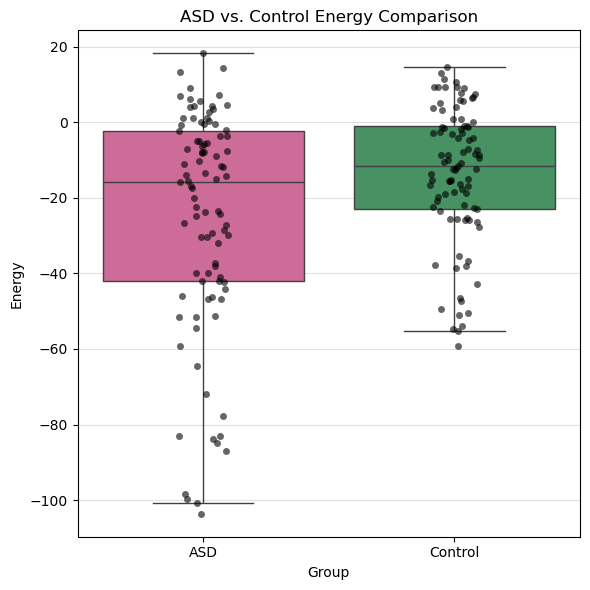

In [3]:
import os
import glob
import math
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.datasets import fetch_atlas_yeo_2011
from scipy.stats import shapiro, levene, ttest_ind, ranksums

###############################################################################
# 1) COEVOLUTIONARY ENERGY FUNCTION
###############################################################################
def compute_energy_from_graph(graph):
    """
    Compute the 2-body coevolutionary energy:
      E = - sum_{(u,v)} [fALFF[u] * weight[u,v] * fALFF[v]],
    skipping edges if any value is NaN or None.
    """
    energy_sum = 0.0
    for u, v, data in graph.edges(data=True):
        falff_u = graph.nodes[u].get('fALFF', None)
        falff_v = graph.nodes[v].get('fALFF', None)
        w = data.get('weight', 0.0)

        # If any is None or NaN, skip this edge
        if falff_u is None or falff_v is None:
            continue
        if np.isnan(falff_u) or np.isnan(falff_v) or np.isnan(w):
            continue

        energy_sum += falff_u * w * falff_v

    # Final energy is negative sum
    E = -energy_sum

    # If E is somehow NaN, we'll detect it in the caller.
    return E

def cohen_d(x, y):
    """
    Compute Cohen's d for two independent samples x, y.
    d = (mean_x - mean_y) / pooled_std
    """
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    nx_ = len(x)
    ny_ = len(y)
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    var_x = np.var(x, ddof=1)
    var_y = np.var(y, ddof=1)
    pooled_var = ((nx_-1)*var_x + (ny_-1)*var_y) / (nx_ + ny_ - 2)
    pooled_std = np.sqrt(pooled_var) if pooled_var>0 else 1e-12
    d = (mean_x - mean_y) / pooled_std
    return d

###############################################################################
# 2) MAIN SCRIPT
###############################################################################
def main():
    # Directories containing the .graphml files
    asd_dir = r"D:\Project_001\NETWORK_FINAL\ASDNetworks\Full"
    control_dir = r"D:\Project_001\NETWORK_FINAL\ControlNetworks\Full"

    # Gather GraphML files
    asd_files = glob.glob(os.path.join(asd_dir, "*.graphml"))
    control_files = glob.glob(os.path.join(control_dir, "*.graphml"))

    if not asd_files:
        print("No ASD graphml files found in:", asd_dir)
    if not control_files:
        print("No Control graphml files found in:", control_dir)
    if (not asd_files) or (not control_files):
        return

    # Lists to store energies
    asd_energies = []
    control_energies = []

    # Process ASD
    for gf in asd_files:
        G = nx.read_graphml(gf)
        E = compute_energy_from_graph(G)
        if np.isnan(E):
            print(f"NaN energy encountered for {gf}, skipping.")
            continue
        asd_energies.append(E)

    # Process Control
    for gf in control_files:
        G = nx.read_graphml(gf)
        E = compute_energy_from_graph(G)
        if np.isnan(E):
            print(f"NaN energy encountered for {gf}, skipping.")
            continue
        control_energies.append(E)

    asd_energies = np.array(asd_energies, dtype=float)
    control_energies = np.array(control_energies, dtype=float)

    print(f"\nFinal sample sizes: ASD={len(asd_energies)}, Control={len(control_energies)}")
    if len(asd_energies)==0 or len(control_energies)==0:
        print("No valid data to compare. Exiting.")
        return
    # Optional for Debugging
    #print("ASD energies:\n", asd_energies)
    #print("Control energies:\n", control_energies)

    # Statistical tests
    print("\n=== Normality Tests (Shapiro–Wilk) ===")
    sw_asd = shapiro(asd_energies)
    sw_ctrl = shapiro(control_energies)
    print(f"ASD: W={sw_asd.statistic:.3f}, p={sw_asd.pvalue:.3g}")
    print(f"Control: W={sw_ctrl.statistic:.3f}, p={sw_ctrl.pvalue:.3g}")

    print("\n=== Levene Test (Equal Variances) ===")
    lev = levene(asd_energies, control_energies)
    print(f"Levene: stat={lev.statistic:.3f}, p={lev.pvalue:.3g}")

    print("\n=== t-test (independent) ===")
    ttest_res = ttest_ind(asd_energies, control_energies, equal_var=(lev.pvalue>0.05))
    print(f"t-test: t={ttest_res.statistic:.3f}, p={ttest_res.pvalue:.3g}")

    print("\n=== Wilcoxon rank-sum test ===")
    ranksum_res = ranksums(asd_energies, control_energies)
    print(f"Rank-sum: stat={ranksum_res.statistic:.3f}, p={ranksum_res.pvalue:.3g}")

    d_val = cohen_d(asd_energies, control_energies)
    print(f"\n=== Effect size (Cohen's d) ===")
    print(f"Cohen's d = {d_val:.3f}")

    # Plot
    import pandas as pd
    plt.figure(figsize=(6,6))
    group_list = ["ASD"]*len(asd_energies) + ["Control"]*len(control_energies)
    energy_list = np.concatenate([asd_energies, control_energies])
    df = pd.DataFrame({"Group": group_list, "Energy": energy_list})

    sns.boxplot(x="Group", y="Energy", data=df, showfliers=False,
                palette=["#dd5c96", "#3c9d5f"])
    sns.stripplot(x="Group", y="Energy", data=df, color="black", size=5,
                  alpha=0.6, jitter=True)
    plt.title("ASD vs. Control Energy Comparison")
    plt.ylabel("Energy")
    plt.grid(True, axis='y', alpha=0.4)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
